In [1]:
# from db_connection import DB_Connection
# import Tweet
import pandas as pd, numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.widgets import TextBox
import re, json
from wordcloud import WordCloud



# db = DB_Connection()

# database = db.query('''SELECT * FROM TWTTWEET WHERE TWEET_CREATED<'2021-01-01'
#                     ORDER BY TWEET_CREATED DESC;''')
# df = pd.DataFrame(database, columns=['id','userid','text','date',
#                             'link','media1','media2','media3', 'media4'])
# df = df.loc[:, ['id', 'text']]


# processed = Tweet.clean_text(df, 'text')
# classified = Tweet.classify_text(processed, 'clean')

# incidents = classified[['id','isIncident']].groupby('isIncident').size()
# accidents = classified[['id','isAccident']].groupby('isAccident').size()[1]
# dangers = classified[['id','isDanger']].groupby('isDanger').size()[1]
# obstacles = classified[['id','isObstacle']].groupby('isObstacle').size()[1]

In [2]:
df = pd.read_csv('../data.csv', encoding='utf-8')

## Text classification

In [3]:
from sklearn.svm import LinearSVC
import pickle
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer1 = CountVectorizer(max_features=700, min_df=5, max_df=0.7)
X11 = vectorizer1.fit_transform(df.clean_text).toarray()

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X11, df.isincident, test_size=0.2, random_state=0)

In [4]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X11, df.isincident, test_size=0.2, random_state=0)

## Boosting Model

In [6]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn import metrics
import xgboost as xgb
import time

### Classifier preliminar

In [14]:
from xgboost import XGBClassifier

start = time.time()
xgb = XGBClassifier(learning_rate=0.3, n_estimators=100, max_depth=9, use_label_encoder=False,
                    min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                    objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
# xgb.fit(X_train, y_train)
xgb.fit(X_train, y_train)
end = time.time()
print('Duration:', str(end-start))

y_xgb = xgb.predict(X_test)

print(confusion_matrix(y_test,y_xgb))
print(classification_report(y_test,y_xgb))
print(accuracy_score(y_test, y_xgb))

[21:26:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Duration: 206.95911240577698
[[ 8803   910]
 [ 1362 19729]]
              precision    recall  f1-score   support

       False       0.87      0.91      0.89      9713
        True       0.96      0.94      0.95     21091

    accuracy                           0.93     30804
   macro avg       0.91      0.92      0.92     30804
weighted avg       0.93      0.93      0.93     30804

0.9262433450201273


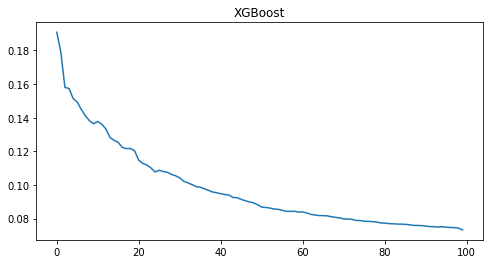

In [26]:
results = xgb.evals_result()
ys = results['validation_0']['error']
xs = [i for i in range(len(ys))]


plt.figure(figsize=(8,4))
plt.title('XGBoost')
# plt.subplot(1, 2, 1)
sns.lineplot(x=xs, y=ys)
plt.show()

#### Estimators adjust

In [ ]:
xgresume = []

for i in [64,128,256,512,1024,2048,4096]:
    print('\nestimators:', str(i))
    start = time.time()
    xgb = XGBClassifier(n_estimators=i, learning_rate=0.3, eval_metric='error') # learning_rate
    xgb.fit(X_train, y_train)
    end = time.time()
    y_xgb = xgb.predict(X_test)
    print(str(end-start), accuracy_score(y_test, y_xgb))
    xgresume.append([i, end-start, accuracy_score(y_test, y_xgb),
    confusion_matrix(y_test,y_xgb), classification_report(y_test,y_xgb)])

In [ ]:
xs = [i[0] for i in xgresume]
ys = [i[2] for i in xgresume]
zs = [i[3] for i in xgresume]

plt.figure(figsize=(11,4))
plt.title('XGBoost')
plt.subplot(1, 2, 1)
sns.pointplot(x=xs, y=ys)
# sns.lineplot(x=range(len(xs)), y=ys, markers=True, style='event')
plt.title('Duración de entrenamiento')
plt.xticks(range(len(xs)), xs)
plt.subplot(1, 2, 2)
sns.pointplot(x=xs, y=zs)
plt.title('Precisión obtenida')
plt.xticks(range(len(xs)), xs)
plt.show()

### Parameters tests

In [7]:
param_test0 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

print(time.asctime())
start = time.time()
gsearch0 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.3, n_estimators=100, max_depth=6, use_label_encoder=False,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                        param_grid = param_test0, scoring='accuracy', n_jobs=1, cv=3, verbose=3)
gsearch0.fit(X_train, y_train, eval_metric='error')
end = time.time()
print(str(end-start))
grid_results0 = pd.DataFrame(gsearch0.cv_results_)
grid_results0.sort_values('rank_test_score').head(5)
grid_results0.to_csv('grid_search0.csv')
gsearch0.best_params_, gsearch0.best_score_

Sun Sep 19 19:55:01 2021
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END ................max_depth=3, min_child_weight=1; total time= 2.4min
[CV 2/3] END ................max_depth=3, min_child_weight=1; total time= 2.1min
[CV 3/3] END ................max_depth=3, min_child_weight=1; total time= 2.1min
[CV 1/3] END ................max_depth=3, min_child_weight=3; total time= 2.1min
[CV 2/3] END ................max_depth=3, min_child_weight=3; total time= 1.8min
[CV 3/3] END ................max_depth=3, min_child_weight=3; total time= 1.9min
[CV 1/3] END ................max_depth=3, min_child_weight=5; total time= 1.8min
[CV 2/3] END ................max_depth=3, min_child_weight=5; total time= 1.8min
[CV 3/3] END ................max_depth=3, min_child_weight=5; total time= 1.9min
[CV 1/3] END ................max_depth=5, min_child_weight=1; total time= 2.7min
[CV 2/3] END ................max_depth=5, min_child_weight=1; total time= 2.8min
[CV 3/3] END ..........

({'max_depth': 9, 'min_child_weight': 1}, 0.9257551971950885)

In [16]:
param_test1 = {
 'gamma':[i/10.0 for i in range(0,4)]
}

print(time.asctime())
start = time.time()
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.3, n_estimators=100, max_depth=9, use_label_encoder=False,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                        param_grid = param_test1, scoring='accuracy',n_jobs=1, cv=3, verbose=3)
gsearch1.fit(X_train, y_train, eval_metric='error')
end = time.time()
print(str(end-start))
grid_results1 = pd.DataFrame(gsearch1.cv_results_)
# grid_results1.sort_values('rank_test_score').head(5)
grid_results1.to_csv('grid_search1.csv')
gsearch1.best_params_, gsearch1.best_score_

Sun Sep 19 21:33:56 2021
Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [ ]:
param_test2 = {
 'subsample':[i/10.0 for i in range(6,11)],
 'colsample_bytree':[i/10.0 for i in range(6,11)]
}

print(time.asctime())
start = time.time()
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.3, n_estimators=100, max_depth=9, use_label_encoder=False,
                                        min_child_weight=1, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                        param_grid = param_test2, scoring='accuracy',n_jobs=4, cv=3, verbose=3)
gsearch2.fit(X_train1, y_train1, eval_metric='error')
end = time.time()
print(str(end-start))
grid_results0 = pd.DataFrame(gsearch0.cv_results_)
# grid_results0.sort_values('rank_test_score').head(5)
grid_results0.to_csv('grid_search0.csv')
gsearch2.best_params_, gsearch2.best_score_

In [13]:
param_test4 = {
 'subsample':[i/10.0 for i in range(8,11)],
 'colsample_bytree':[i/10.0 for i in range(8,11)]
}

print(time.asctime())
start = time.time()
gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.3, n_estimators=100, max_depth=9, use_label_encoder=False,
                                        min_child_weight=1, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                        param_grid = param_test4, scoring='accuracy',n_jobs=4, cv=3, verbose=3)
gsearch4.fit(X_train1, y_train1, eval_metric='error')
end = time.time()
print(str(end-start))
grid_results0 = pd.DataFrame(gsearch0.cv_results_)
# grid_results0.sort_values('rank_test_score').head(5)
grid_results0.to_csv('grid_search0.csv')
gsearch4.best_params_, gsearch4.best_score_

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[15:16:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'colsample_bytree': 0.8, 'subsample': 0.8}, 0.9812265777511792)

In [16]:
param_test3 = {
 'reg_alpha':[0, 1e-5, 0.001, 0.005, 0.01, 0.05, 0.1]
}

print(time.asctime())
start = time.time()
gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.3, n_estimators=100, max_depth=9,
                                        min_child_weight=1, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                        param_grid = param_test3, scoring='accuracy',n_jobs=4, cv=3, verbose=3)
gsearch3.fit(X_train, y_train, eval_metric='error')
end = time.time()
print(str(end-start))
grid_results0 = pd.DataFrame(gsearch0.cv_results_)
grid_results0.sort_values('rank_test_score').head(5)
grid_results0.to_csv('grid_search0.csv')
gsearch3.best_params_, gsearch3.best_score_

Fitting 3 folds for each of 7 candidates, totalling 21 fits
[15:51:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'reg_alpha': 0.005}, 0.9812622009433021)

In [28]:
grid_results3 = pd.DataFrame(gsearch3.cv_results_)
grid_results3.sort_values('rank_test_score').head(5)#[['rank_test_score','param_colsample_bytree', 'param_subsample', 'mean_test_score', 'std_test_score']].rename(columns={'param_colsample_bytree':'colsample_bytree', 'param_param_subsample':'subsample'})
grid_results3.to_csv('grid_search_results3-4.csv')

NameError: name 'gsearch3' is not defined

In [ ]:
xgb1 = XGBClassifier(
    learning_rate=0.3,
    n_estimators=2000,
    max_depth=9, min_child_weight=1,
    gamma=0.1, subsample=0.9, colsample_bytree=1,
    nthread=4, seed=27, verbosity=3)

xgb_param = xgb1.get_xgb_params()
xgtrain = xgb.DMatrix(X_train, label=y_train)
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=xgb1.get_params()['n_estimators'], nfold=5,
    early_stopping_rounds=50)
xgb1.set_params(n_estimators=cvresult.shape[0])

In [ ]:
#Fit the algorithm on the data
print('Start training.')
start = time.time()
xgb1.fit(X_train, y_train, verbose=True)
print('End training.') 
end = time.time()
    
#Predict training set:
dtrain_predictions = xgb1.predict(X_test)
dtrain_predprob = xgb1.predict_proba(X_test)[:,1]
    
#Print model report:
print("\nModel Report")
print("Duration:", str(end-start))
print("Accuracy : %.4g" % metrics.accuracy_score(y_test, dtrain_predictions))
print("AUC Score (Train): %f" % metrics.roc_auc_score(y_test, dtrain_predprob))
                
plt.figure(figsize=(15,5))
feat_imp = pd.Series(xgb1.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

### Estimators adjust

In [20]:
xgresume = []
xgb_arr = []

for i in [512,1024,2048]:
    print('\nestimators:', str(i))
    start = time.time()
    xgb = XGBClassifier(
        learning_rate=0.3,
        n_estimators=i,
        max_depth=9, min_child_weight=1,
        gamma=0.1, subsample=0.8, colsample_bytree=0.8,
        reg_alpha=0.005,
        nthread=4, seed=27, eval_metric='error', verbosity=0)
    xgb_arr.append(xgb)
    print('Fitting... ', time.asctime())
    xgb_arr[-1].fit(X_train1, y_train1)
    end = time.time()
    print('Predicting... ', time.asctime())
    y_xgb = xgb_arr[-1].predict(X_test1)
    print(str(end-start), accuracy_score(y_test1, y_xgb))
    xgresume.append([i, end-start, accuracy_score(y_test1, y_xgb),
    confusion_matrix(y_test1,y_xgb), classification_report(y_test1,y_xgb)])


estimators: 512
Fitting...  Thu Feb 18 16:02:16 2021
Predicting...  Thu Feb 18 16:12:24 2021
608.3386294841766 0.9828441151325163

estimators: 1024
Fitting...  Thu Feb 18 16:12:25 2021
Predicting...  Thu Feb 18 16:40:20 2021
1675.0280911922455 0.9831290966087204

estimators: 2048
Fitting...  Thu Feb 18 16:40:21 2021
Predicting...  Thu Feb 18 17:36:28 2021
3366.2757561206818 0.9827016243944143


In [21]:
for i in xgresume:
    for s in i: print(s)
    print('\n')

512
608.3386294841766
0.9828441151325163
[[18547    81]
 [  521 15941]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18628
           1       0.99      0.97      0.98     16462

    accuracy                           0.98     35090
   macro avg       0.98      0.98      0.98     35090
weighted avg       0.98      0.98      0.98     35090



1024
1675.0280911922455
0.9831290966087204
[[18532    96]
 [  496 15966]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18628
           1       0.99      0.97      0.98     16462

    accuracy                           0.98     35090
   macro avg       0.98      0.98      0.98     35090
weighted avg       0.98      0.98      0.98     35090



2048
3366.2757561206818
0.9827016243944143
[[18501   127]
 [  480 15982]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18628
           1 

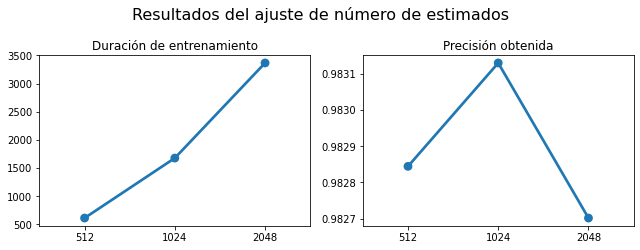

In [72]:
xs = [i[0] for i in xgresume]
ys = [i[1] for i in xgresume]
zs = [i[2] for i in xgresume]

plt.figure(figsize=(9,3.5))
plt.suptitle('Resultados del ajuste de número de estimados', fontsize=16)
plt.subplot(1, 2, 1)
sns.pointplot(x=xs, y=ys)
plt.title('Duración de entrenamiento')
plt.xticks(range(len(xs)), xs)
plt.subplot(1, 2, 2)
sns.pointplot(x=xs, y=zs)
plt.title('Precisión obtenida')
plt.xticks(range(len(xs)), xs)
plt.tight_layout()
plt.show()

In [91]:
with open('xgbresume0', 'wb') as picklefile:
    pickle.dump(xgresume, picklefile)
with open('xgbarr0', 'wb') as picklefile:
    pickle.dump(xgb_arr, picklefile)

In [23]:
xgresume1 = []
xgb_arr1 = []

for i in [600,700,800,900]:
    print('\nestimators:', str(i))
    start = time.time()
    xgb = XGBClassifier(
        learning_rate=0.3,
        n_estimators=i,
        max_depth=9, min_child_weight=1,
        gamma=0.1, subsample=0.8, colsample_bytree=0.8,
        reg_alpha=0.005,
        nthread=4, seed=27, eval_metric='error', verbosity=0)
    xgb_arr1.append(xgb)
    xgb_arr1[-1].fit(X_train1, y_train1)
    end = time.time()
    y_xgb = xgb_arr1[-1].predict(X_test1)
    print(str(end-start), accuracy_score(y_test1, y_xgb))
    xgresume1.append([i, end-start, accuracy_score(y_test1, y_xgb),
    confusion_matrix(y_test1,y_xgb), classification_report(y_test1,y_xgb)])


estimators: 600
843.4114825725555 0.982958107722998

estimators: 700
1159.8502888679504 0.9829866058706184

estimators: 800
1267.0512402057648 0.9830151040182388

estimators: 900
1491.8558073043823 0.9831290966087204


In [27]:
for i in xgresume1:
    for s in i: print(s)
    print('\n')

600
843.4114825725555
0.982958107722998
[[18542    86]
 [  512 15950]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18628
           1       0.99      0.97      0.98     16462

    accuracy                           0.98     35090
   macro avg       0.98      0.98      0.98     35090
weighted avg       0.98      0.98      0.98     35090



700
1159.8502888679504
0.9829866058706184
[[18536    92]
 [  505 15957]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18628
           1       0.99      0.97      0.98     16462

    accuracy                           0.98     35090
   macro avg       0.98      0.98      0.98     35090
weighted avg       0.98      0.98      0.98     35090



800
1267.0512402057648
0.9830151040182388
[[18533    95]
 [  501 15961]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18628
           1    

In [85]:
[i[0] for i in xgresume1] + [xgresume[1][0]]

[600, 700, 800, 900, 1024]

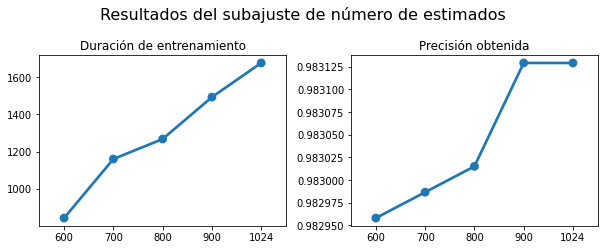

In [87]:
xs = [i[0] for i in xgresume1] + [xgresume[1][0]]
ys = [i[1] for i in xgresume1] + [xgresume[1][1]]
zs = [i[2] for i in xgresume1] + [xgresume[1][2]]

plt.figure(figsize=(8.5,3.5))
plt.suptitle('Resultados del subajuste de número de estimados', fontsize=16)
plt.subplot(1, 2, 1)
sns.pointplot(x=xs, y=ys)
plt.title('Duración de entrenamiento')
plt.xticks(range(len(xs)), xs)
plt.subplot(1, 2, 2)
sns.pointplot(x=xs, y=zs)
plt.title('Precisión obtenida')
plt.xticks(range(len(xs)), xs)
plt.tight_layout()
plt.show()

In [92]:
with open('xgbresume1', 'wb') as picklefile:
    pickle.dump(xgresume1, picklefile)
with open('xgbarr1', 'wb') as picklefile:
    pickle.dump(xgb_arr1, picklefile)

In [8]:
print('\nestimators: 1000')
start = time.time()
xgb_final = XGBClassifier(
    learning_rate=0.3,
    n_estimators=1000,
    max_depth=9, min_child_weight=1,
    gamma=0.1, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.005,
    nthread=4, seed=27, eval_metric='error', verbosity=0)
xgb_final.fit(X_train, y_train)
end = time.time()
y_xgb = xgb_final.predict(X_test)
print(str(end-start), accuracy_score(y_test, y_xgb))


estimators: 700
1089.302880525589 0.9828726132801368


In [77]:
xgb_final = xgb_arr1[-1]
y_xgb = xgb_final.predict(X_test1)
xgb_final

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric='error',
              gamma=0.1, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=9, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=900, n_jobs=4, nthread=4,
              num_parallel_tree=1, random_state=27, reg_alpha=0.005,
              reg_lambda=1, scale_pos_weight=1, seed=27, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=0)

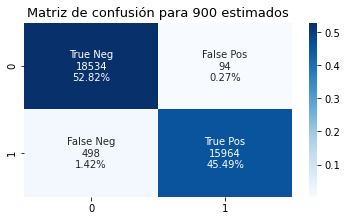

In [82]:
xgb_con = confusion_matrix(y_test1,y_xgb)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                xgb_con.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     xgb_con.flatten()/np.sum(xgb_con)]
labels = ['%s\n%s\n%s' % (v1, v2, v3) for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(6,3.2))
sns.heatmap(xgb_con/np.sum(xgb_con), annot=labels, fmt='', cmap='Blues')
plt.title('Matriz de confusión para 900 estimados', fontsize=13)
plt.show()

In [25]:
with open('xgb_classifier', 'wb') as picklefile:
    pickle.dump(xgb_final, picklefile)

## Count vectors adjust

In [29]:
# load model
with open('xgb_classifier', 'rb') as training_model:
    xgb = pickle.load(training_model)

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# xgresume2 = []
# xgb_arr2 = []

# for i in [600, 700, 800, 900, 1000, 1500]:
for i in [2000, 2500, 3000]:
    print('\nnumber of features:', str(i))
    vectorizer = CountVectorizer(max_features=i, min_df=4, max_df=0.7)
    print('Fitting vectorizer...')
    X1 = vectorizer.fit_transform(df.clean_text).toarray()
    print('Creating train-test data...')
    X_train, X_test, y_train, y_test = train_test_split(X1, df.isincident, test_size=0.2, random_state=0)
    print('Fitting model...', time.asctime())

    model = XGBClassifier(use_label_encoder=False)
    xgb_arr2.append(model)
    # with open('xgb_classifier', 'rb') as training_model:
    #     xgb_arr2.append(pickle.load(training_model))
    
    start = time.time()
    xgb_arr2[-1].fit(X_train,y_train)
    end = time.time()
    print('Fitting time:', str(end-start), '\nPredicting...')
    y_xgb = xgb_arr2[-1].predict(X_test)
    print(accuracy_score(y_test, y_xgb))
    print(confusion_matrix(y_test,y_xgb))
    print(classification_report(y_test,y_xgb))
    xgresume2.append([i, end-start, accuracy_score(y_test, y_xgb),
    confusion_matrix(y_test,y_xgb), classification_report(y_test,y_xgb)])


number of features: 2000
Fitting vectorizer...
Creating train-test data...
Fitting model... Sat Sep 18 20:57:03 2021
[20:57:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


KeyboardInterrupt: 

In [93]:
with open('xgbresume2', 'wb') as picklefile:
    pickle.dump(xgresume2, picklefile)
with open('xgbarr2', 'wb') as picklefile:
    pickle.dump(xgb_arr2, picklefile)

In [7]:
# load model
# with open('./others/resumes/xgbarr2', 'rb') as arr:
#     xgb_arr2 = pickle.load(arr)
# with open('./others/resumes/xgbresume2', 'rb') as resume:
#     xgresume2 = pickle.load(resume)
with open('./others/resumes/xgbresume2-2', 'rb') as resume:
    xgresume2 = pickle.load(resume)

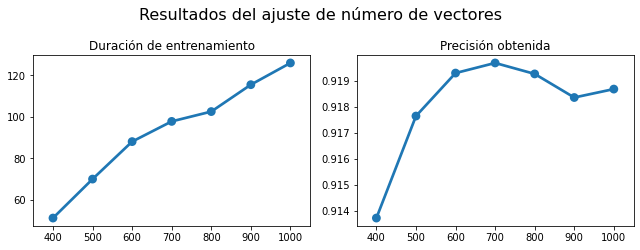

In [16]:
xg = xgresume2[:-1]

xs = [i[0] for i in xg]
ys = [i[1] for i in xg]
zs = [i[2] for i in xg]

plt.figure(figsize=(9,3.5))
plt.suptitle('Resultados del ajuste de número de vectores', fontsize=16)
plt.subplot(1, 2, 1)
sns.pointplot(x=xs, y=ys)
plt.title('Duración de entrenamiento')
plt.xticks(range(len(xs)), xs)
plt.subplot(1, 2, 2)
sns.pointplot(x=xs, y=zs)
plt.title('Precisión obtenida')
plt.xticks(range(len(xs)), xs)
plt.tight_layout()
plt.show()

In [52]:
# save final xgb model
xgb_final2 = xgb_arr2[-1]

In [17]:
# fit vectorizer 5000 features
i = 5000
print('\nnumber of features:', str(i))
vectorizer10 = CountVectorizer(max_features=i, min_df=5, max_df=0.7)
print('Fitting vectorizer...', time.asctime())
vectorizer10.fit(classified.clean)


number of features: 5000
Fitting vectorizer... Fri Feb 19 13:58:13 2021
Creating train-test data...


In [5]:
# convert and split data
X_vect = vect.transform(classified.clean).toarray()
print('Creating train-test data...')
X_train, X_test, y_train, y_test = train_test_split(X_vect, classified.isIncident, test_size=0.2, random_state=0)
print('Done.')

Creating train-test data...


In [18]:
with open('vectorizer5000', 'wb') as picklefile:
    pickle.dump(vectorizer10, picklefile)

In [4]:
# load model fo 5000 features
with open('count_vectorizer', 'rb') as v:
    vect = pickle.load(v)

In [6]:
#load model
with open('xgb_5000', 'rb') as training_model:
    xgb_classifier = pickle.load(training_model)

In [ ]:
# fit classifier with 5000 features
print('Fitting model...', time.asctime())
start = time.time()
xgb_classifier.fit(X_train,y_train)
end = time.time()
print('Fitting time:', str(end-start), '\nPredicting...')

In [7]:
# predict test data
print('Predicting data...')
y_xgb2 = xgb_classifier.predict(X_test)
print(accuracy_score(y_test, y_xgb2))
print(confusion_matrix(y_test,y_xgb2))
print(classification_report(y_test,y_xgb2))
# xgresume2.append([i, end-start, accuracy_score(y_test, y_xgb2),
# confusion_matrix(y_test,y_xgb2), classification_report(y_test,y_xgb2)])

0.9981191222570532
[[18618     7]
 [   59 16406]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18625
           1       1.00      1.00      1.00     16465

    accuracy                           1.00     35090
   macro avg       1.00      1.00      1.00     35090
weighted avg       1.00      1.00      1.00     35090



In [ ]:
# save trained classifier
with open('xgb_features_final', 'wb') as picklefile:
    pickle.dump(xgb_classifier, picklefile)

In [29]:
# count vectors for 10000
i = 10000
print('\nnumber of features:', str(i))
vectorizer100 = CountVectorizer(max_features=i, min_df=5, max_df=0.7)
print('Fitting vectorizer...', time.asctime())
vectorizer100.fit(classified.clean)
X_vect1 = vectorizer100.transform(classified.clean).toarray()
print('Creating train-test data...')
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_vect1, classified.isIncident, test_size=0.2, random_state=0)
with open('vectorizer10000', 'wb') as picklefile:
    pickle.dump(vectorizer100, picklefile)


number of features: 10000
Fitting vectorizer... Fri Feb 19 16:16:47 2021
Creating train-test data...


In [ ]:
# fitting 10000 vectors
#load model
with open('xgb_classifier', 'rb') as model:
    xgb_classifier1 = pickle.load(model)
print('Fitting model...', time.asctime())
start = time.time()
xgb_classifier1.fit(X_train3,y_train3)
end = time.time()
print('Fitting time:', str(end-start), '\nPredicting...')
y_xgb3 = xgb_classifier1.predict(X_test3)
print(accuracy_score(y_test3, y_xgb3))
print(confusion_matrix(y_test3,y_xgb3))
print(classification_report(y_test3,y_xgb3))
# xgresume2.append([i, end-start, accuracy_score(y_test, y_xgb3),
# confusion_matrix(y_test,y_xgb3), classification_report(y_test,y_xgb3)])

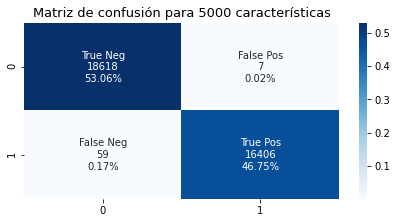

In [8]:
xgb_con = confusion_matrix(y_test,y_xgb2)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                xgb_con.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     xgb_con.flatten()/np.sum(xgb_con)]
labels = ['%s\n%s\n%s' % (v1, v2, v3) for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(6,3.2))
sns.heatmap(xgb_con/np.sum(xgb_con), annot=labels, fmt='', cmap='Blues')
plt.title('Matriz de confusión para 5000 características', fontsize=13)
plt.tight_layout()
plt.show()

Text(0.5, 0, '')

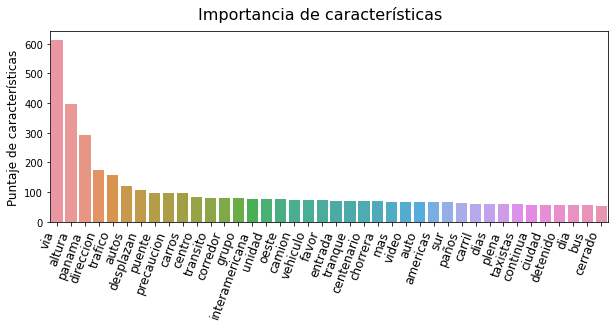

In [28]:
feat_df = pd.DataFrame(X_vect)
feat_df.columns = vect.get_feature_names()

plt.figure(figsize=(10,3.5))
feat_imp = pd.Series(xgb_classifier.get_booster().get_fscore()).sort_values(ascending=False)[:40]
# feat_imp.plot(kind='bar', title='Feature] Importances')
feat_values = [int(re.sub('f', '', i)) for i in feat_imp.index]
feat_names = [feat_df.columns[i] for i in feat_values]
features = pd.DataFrame({'feature_num':feat_values, 'names':feat_names, 'count':feat_imp.values})
# plt.bar(x=feat_values, height=feat_imp.values)
# sns.barplot(x=feat_values, y=feat_imp.values, data=feat_imp, order=feat_imp.values)
plt.suptitle('Importancia de características', fontsize=16)
# plt.subplot(2, 1, 1)
sns.barplot(x='names', y='count', data=features)
plt.xticks(rotation=70, fontsize=12, ha='right')
plt.ylabel('Puntaje de características', fontsize=12)
# plt.tight_layout()
plt.xlabel(None)